In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from scipy.signal import detrend

In [39]:
# --- Grid, sampling, and wave parameters ---
nx = ny = 128
Fs = 157.0                 # frames per second
duration = 2.0             # seconds
nt = int(Fs * duration)

# Spatial coordinates (centered at 0 so geometry is symmetric)
x = np.arange(nx) - (nx - 1)/2
y = np.arange(ny) - (ny - 1)/2
X, Y = np.meshgrid(x, y, indexing='xy')

t = np.arange(nt) / Fs     # seconds

# Choose a long wavelength so only ~1–2 cycles fit across the frame
lam_px = 150.0             # spatial wavelength in pixels
c_px_s = 200.0             # wave speed in pixels/second  (so f = c/λ = ~2.0 Hz)
f_hz = c_px_s / lam_px
T_period = 1.0 / f_hz
print(f"Temporal frequency ~ {f_hz:.2f} Hz, period ~ {T_period:.2f} s")

Temporal frequency ~ 1.33 Hz, period ~ 0.75 s


In [40]:
def plane_wave(X, Y, t, lam_px, c_px_s, theta_deg=30.0):
    """
    Plane wave with straight fronts moving at speed c along angle theta.
    Returns movie shaped (ny, nx, nt).
    """
    theta = np.deg2rad(theta_deg)
    S = (X * np.cos(theta) + Y * np.sin(theta))[:, :, None]     # (ny,nx,1)
    phase = (2*np.pi/lam_px) * (S - c_px_s * t[None, None, :])  # broadcast over t
    return np.cos(phase)

def curved_fronts(X, Y, t, lam_px, c_px_s, center):
    """
    Moderately curved fronts: treat as a circular wave from a source far outside the FOV.
    'center' should be a tuple (x0, y0) in pixel coordinates relative to the centered grid.
    """
    x0, y0 = center
    R = np.sqrt((X - x0)**2 + (Y - y0)**2)[:, :, None]
    phase = (2*np.pi/lam_px) * (R - c_px_s * t[None, None, :])
    return np.cos(phase)

def radial_wave(X, Y, t, lam_px, c_px_s, center=(0.0, 0.0)):
    """
    Radially expanding wave with source inside the FOV (concentric rings).
    """
    x0, y0 = center
    R = np.sqrt((X - x0)**2 + (Y - y0)**2)[:, :, None]
    phase = (2*np.pi/lam_px) * (R - c_px_s * t[None, None, :])
    return np.cos(phase)

In [41]:
movie_plane  = plane_wave(X, Y, t, lam_px, c_px_s, theta_deg=35.0)

# Put the “far source” ≈ 2–3 FOV widths away to get gentle curvature
far_center = (-3.0*nx, 0.0)   # far to the left of the frame, near mid-height
movie_curved = curved_fronts(X, Y, t, lam_px, c_px_s, center=far_center)

# Source at the center for the radial case
movie_radial = radial_wave(X, Y, t, lam_px, c_px_s, center=(0.0, 0.0))

movies = {
    "Plane wave": movie_plane,
    "Curved fronts": movie_curved,
    "Radial expansion": movie_radial
}

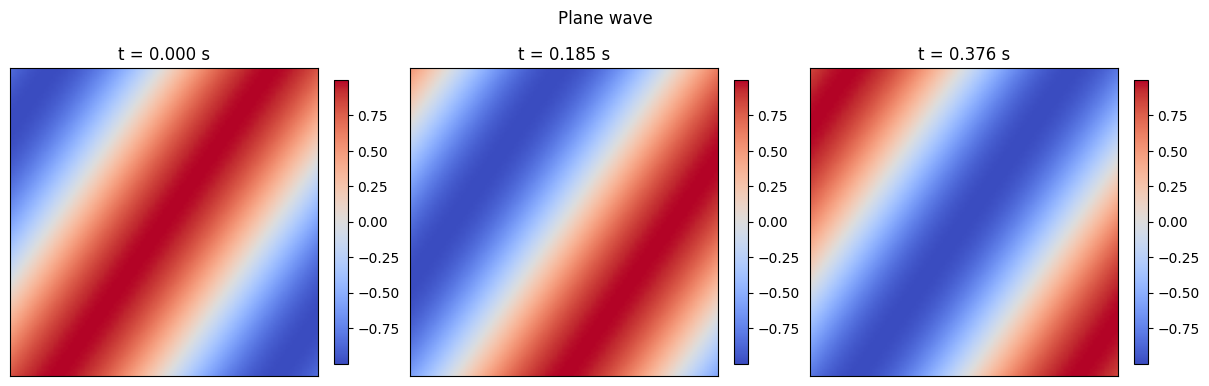

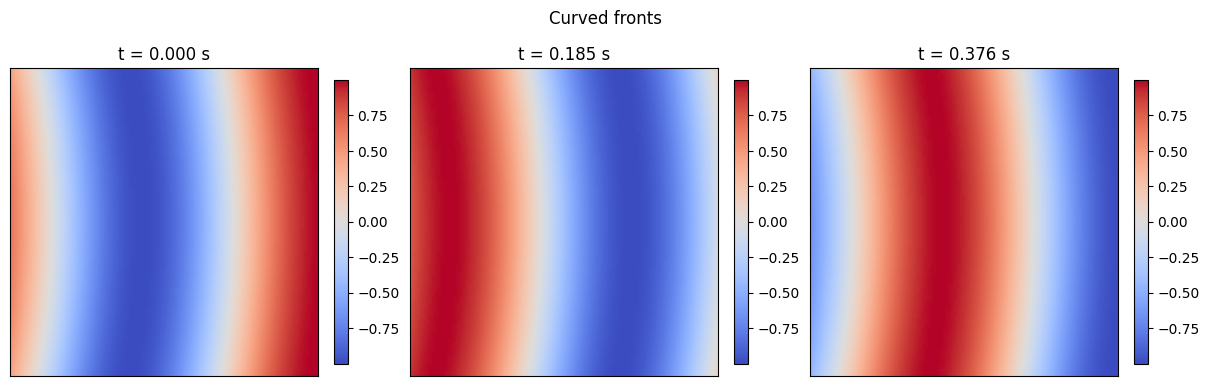

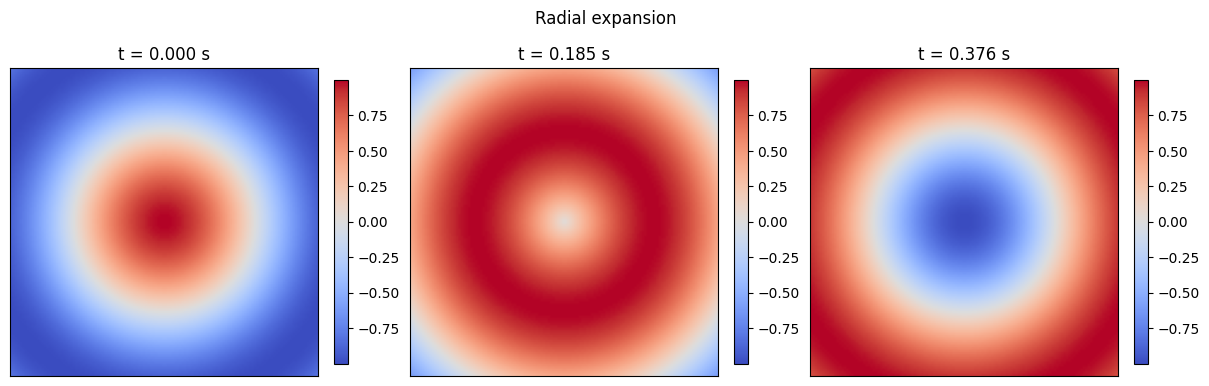

In [42]:
def show_snapshots(movie, t_indices, suptitle=None, cmap='coolwarm'):
    """Show a few frames with consistent, symmetric color limits."""
    import matplotlib.pyplot as plt

    frames = [movie[:, :, ti] for ti in t_indices]
    vmax = np.quantile(np.abs(np.stack(frames, axis=-1)), 0.995)
    vmax = float(max(vmax, 1e-6))

    n = len(t_indices)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), constrained_layout=True)
    if n == 1:
        axes = [axes]

    for ax, ti in zip(axes, t_indices):
        im = ax.imshow(movie[:, :, ti], origin='upper',
                       cmap=cmap, vmin=-vmax, vmax=vmax)
        ax.set_title(f"t = {t[ti]:.3f} s")
        ax.set_xticks([]); ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046)

    if suptitle:
        fig.suptitle(suptitle, y=1.03, fontsize=12)
    plt.show()

# Choose three phases across ~half a cycle
t0 = 0
t_quarter = int(round((T_period/4) * Fs))
t_half    = int(round((T_period/2) * Fs))

for name, mov in movies.items():
    show_snapshots(mov, [t0, t_quarter, t_half], suptitle=name)

In [43]:
def seed_xcorr_delay_maps(movie, Fs, seed_xy,
                          max_lag_s=None, detrend_ts=True):
    """
    Compute seed-pixel cross-correlation X_j(tau), the delay map tau_max(x,y),
    and the peak-corr map for a 3D movie (ny, nx, nt).

    Parameters
    ----------
    movie : ndarray, shape (ny, nx, nt)
    Fs    : float, sampling rate [Hz]
    seed_xy : (xs, ys) ints or floats; pixel indices in (x, y) order
    max_lag_s : float or None; maximum lag (seconds) to consider around 0.
                 If None, defaults to 0.5 * (movie duration).
                 Recommended: 0.3–0.6 * period.
    detrend_ts : bool; if True, remove linear trend per pixel before z-scoring.

    Returns
    -------
    tau_map     : (ny, nx) float seconds; lag at which corr is maximal
    corr_peak   : (ny, nx) float; peak correlation value [-1,1]
    lags_s      : (L,) float array of lags in seconds (for the full correlation)
    xcorr_seed  : (ny, nx, L) float array of cross-correlations (optional large)
                  NOTE: by default we don't return to save memory; see comment.
    """
    ny, nx, nt = movie.shape
    xs, ys = seed_xy
    xs = int(round(xs)); ys = int(round(ys))

    # --- time preprocessing: (optional) detrend and z-score each pixel ---
    V = movie.copy().astype(float)
    if detrend_ts:
        V = detrend(V, axis=2, type='linear')
    mu = V.mean(axis=2, keepdims=True)
    sd = V.std(axis=2, keepdims=True) + 1e-12
    V = (V - mu) / sd

    # Seed time series (z-scored already)
    v_seed = V[ys, xs, :]                      # shape (nt,)

    # --- Cross-correlation via convolution theorem ---
    # Full discrete cross-corr length = 2*nt-1, centered at lag=0
    n_full = 2*nt - 1

    # rFFT along time for all pixels and for the seed
    # (Use real FFT; need an n that will produce n_full time-points after irfft.)
    # For full linear correlation, we need circular correlation on a length n_full.
    n_fft = n_full
    V_f = rfft(V, n=n_fft, axis=2)             # (ny, nx, n_fft//2+1)
    seed_f = rfft(v_seed[None, None, :], n=n_fft, axis=2).conj()  # (1,1,K)

    # Elementwise multiply in Fourier domain and invert
    xcorr = irfft(V_f * seed_f, n=n_fft, axis=2)  # (ny, nx, n_full)

    # Build lag array. With our definition, positive tau means the pixel lags the seed
    # (i.e., we correlate V_seed(t) with V_j(t - tau)).
    # With the FFT form above, the "zero-lag" is at index (nt-1).
    lags = np.arange(-nt+1, nt)                 # in samples
    lags_s = lags / Fs

    # --- Focus on a window of lags around 0 ---
    if max_lag_s is None:
        max_lag_s = 0.5 * (nt / Fs)             # liberal default (half duration)
    Lmax = int(np.floor(max_lag_s * Fs))
    keep = (lags >= -Lmax) & (lags <= Lmax)
    xcorr_win = xcorr[:, :, keep]
    lags_win_s = lags_s[keep]

    # --- Find peak correlation and argmax lag per pixel ---
    idx = np.argmax(xcorr_win, axis=2)          # (ny, nx) indices into window
    corr_peak = np.take_along_axis(xcorr_win, idx[..., None], axis=2)[..., 0]
    tau_map = lags_win_s[idx]

    # Optional: return the full xcorr window too, but it's big; comment out by default
    # return tau_map, corr_peak, lags_win_s, xcorr_win

    return tau_map, corr_peak, lags_win_s, xcorr_win

In [44]:
# Choose which movie to analyze:
movie = movie_plane       # or movie_curved or movie_radial
seed_xy = (nx//2, ny//2)   # (x, y)

# Choose a reasonable max lag window: e.g., 0.6 * period
max_lag_s = 0.6 * T_period

tau_map, corr_peak, lags_s, xcorr_seed = seed_xcorr_delay_maps(
    movie, Fs, seed_xy, max_lag_s=max_lag_s, detrend_ts=True
)

In [37]:
from numpy.fft import rfft, irfft
from collections import deque
from scipy.signal import detrend

def seed_xcorr_delay_maps_unwrap(movie, Fs, seed_xy, period_s,
                                 detrend_ts=True, normalize=True):
    """
    1) Full-lag normalized seed xcorr.
    2) Argmax per pixel -> raw delays tau_raw (seconds).
    3) 2-D spatial unwrapping of tau_raw by adding multiples of T so that
       neighboring differences are < T/2 (starting from seed).

    Returns
    -------
    tau_unwrapped : (ny, nx) continuous delays (s)
    corr_peak     : (ny, nx) peak correlations [-1,1]
    """
    ny, nx, nt = movie.shape
    xs, ys = map(int, map(round, seed_xy))
    T = float(period_s)

    # ---- full xcorr (like before) ----
    V = movie.astype(float, copy=True)
    if detrend_ts:
        V = detrend(V, axis=2, type='linear')
    V = (V - V.mean(axis=2, keepdims=True)) / (V.std(axis=2, keepdims=True) + 1e-12)

    v_seed = V[ys, xs, :]

    n_full = 2*nt - 1
    V_f    = rfft(V, n=n_full, axis=2)
    seed_f = rfft(v_seed[None, None, :], n=n_full, axis=2).conj()
    xcorr  = irfft(V_f * seed_f, n=n_full, axis=2)

    lags = np.arange(-nt+1, nt)
    if normalize:
        xcorr = xcorr / (nt - np.abs(lags))[None, None, :]

    lags_s = lags / Fs
    idx = np.argmax(xcorr, axis=2)
    tau_raw = lags_s[idx]
    corr_peak = np.take_along_axis(xcorr, idx[..., None], axis=2)[..., 0]

    # ---- 2-D spatial unwrapping on tau_raw ----
    tau = np.full_like(tau_raw, np.nan, dtype=float)
    visited = np.zeros((ny, nx), dtype=bool)

    def neighbors(i, j):
        if i > 0:       yield i-1, j
        if i < ny-1:    yield i+1, j
        if j > 0:       yield i, j-1
        if j < nx-1:    yield i, j+1

    q = deque()
    tau[ys, xs] = tau_raw[ys, xs]
    visited[ys, xs] = True
    q.append((ys, xs))

    # Adjust neighbor by adding k*T so that |delta| < T/2
    halfT = 0.5 * T
    while q:
        i, j = q.popleft()
        base = tau[i, j]
        for ii, jj in neighbors(i, j):
            if visited[ii, jj]:
                continue
            cand = tau_raw[ii, jj]
            # bring cand close to base by adding multiples of T
            k = np.round((base - cand) / T)
            cand_adj = cand + k * T
            # after adjustment, ensure the difference is in (-T/2, T/2]
            if cand_adj - base > halfT:
                cand_adj -= T
            elif cand_adj - base <= -halfT:
                cand_adj += T
            tau[ii, jj] = cand_adj
            visited[ii, jj] = True
            q.append((ii, jj))

    return tau, corr_peak

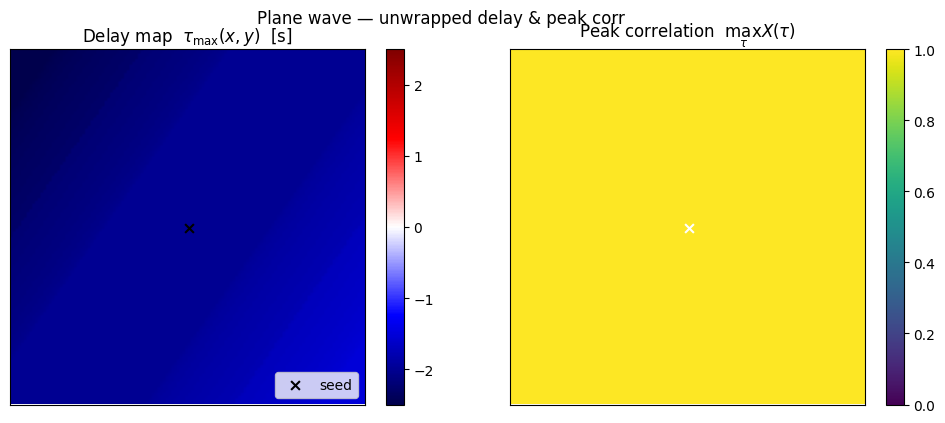

In [38]:
tau_unwrapped, corr_peak = seed_xcorr_delay_maps_unwrap(
    movie_plane, Fs, seed_xy=(nx//2, ny//2), period_s=lam_px / c_px_s,
    detrend_ts=True, normalize=True
)

plot_seed_results(tau_unwrapped, corr_peak, (nx//2, ny//2),
                  title_prefix="Plane wave — unwrapped delay & peak corr")

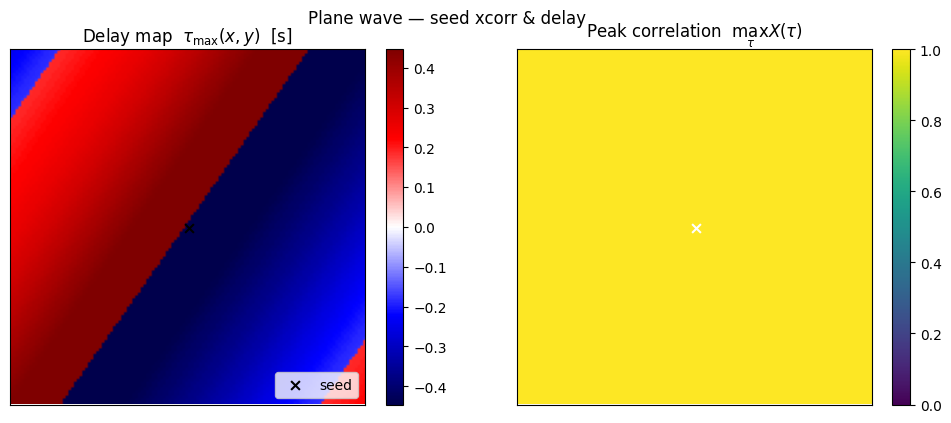

In [45]:
def plot_seed_results(tau_map, corr_peak, seed_xy, lags_s=None, xcorr_seed=None,
                      title_prefix="Seed xcorr results"):
    import matplotlib.pyplot as plt
    ny, nx = tau_map.shape
    xs, ys = seed_xy

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    # Delay map (diverging cmap centered at 0)
    vmax = np.max(np.abs(tau_map[np.isfinite(tau_map)]))
    im0 = axes[0].imshow(tau_map, origin='upper', cmap='seismic',
                         vmin=-vmax, vmax=vmax)
    axes[0].scatter([xs], [ys], s=40, c='k', marker='x', label='seed')
    axes[0].set_title("Delay map  $\\tau_{\\max}(x,y)$  [s]")
    axes[0].legend(loc='lower right', frameon=True)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    # Peak correlation map
    im1 = axes[1].imshow(corr_peak, origin='upper', cmap='viridis',
                         vmin=0.0, vmax=1.0)
    axes[1].scatter([xs], [ys], s=40, c='w', marker='x', label='seed')
    axes[1].set_title("Peak correlation  $\\max_\\tau X(\\tau)$")
    axes[1].set_xticks([]); axes[1].set_yticks([])
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    fig.suptitle(title_prefix, y=1.02)
    plt.show()

plot_seed_results(tau_map, corr_peak, seed_xy,
                  title_prefix="Plane wave — seed xcorr & delay")

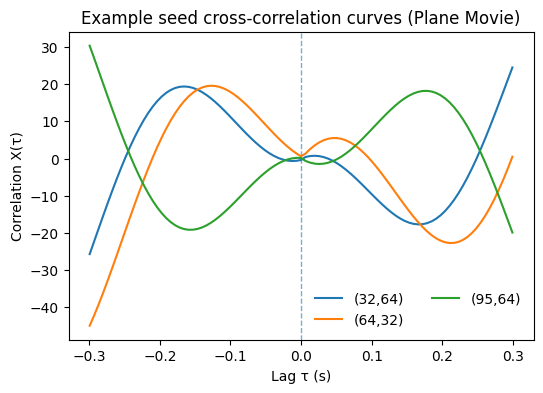

In [25]:
def plot_example_xcorr_curves(movie, seed_xy, lags_s, xcorr_win,
                              picks=((0.25,0.5), (0.5,0.25), (0.75,0.5))):
    """
    Plot X_j(tau) for a few sample pixels specified as fractions of the frame.
    'picks' are (fx, fy) with fx,fy in [0,1]; we convert to pixel indices.
    """
    import matplotlib.pyplot as plt
    ny, nx, L = xcorr_win.shape
    xs, ys = seed_xy

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(0, ls='--', lw=1, alpha=0.6)
    ax.set_xlabel("Lag τ (s)")
    ax.set_ylabel("Correlation X(τ)")
    ax.set_title("Example seed cross-correlation curves (Plane Movie)")

    for fx, fy in picks:
        jx = int(round(fx * (nx-1)))
        jy = int(round(fy * (ny-1)))
        ax.plot(lags_s, xcorr_win[jy, jx, :], label=f'({jx},{jy})')

    ax.legend(frameon=False, ncol=2)
    plt.show()

plot_example_xcorr_curves(movie, seed_xy, lags_s, xcorr_seed)